In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Input, Concatenate, UpSampling2D, BatchNormalization, Activation, Add, MaxPool2D, Dense, Embedding, LayerNormalization, Add, MultiHeadAttention, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomCrop, GaussianNoise
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
import gc

In [3]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout, SpatialDropout2D

In [4]:
# Read and examine metadata
#raw_data = pd.read_csv(r"/content/drive/MyDrive/COVID-19 Lung CT Scan Segmentation/metadata_COLAB.csv")
raw_data = pd.read_csv(r"../COVID-19 Lung CT Scan Segmentation/COVID-19 Lung CT Scan Segmentation/metadata_temp.csv")
raw_data.sample(5)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
13,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
0,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
14,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
8,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...
3,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...,C:\Application\Programming\Research\Lung_Segme...


In [5]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [6]:
# Read sample
sample_ct   = read_nii(raw_data.loc[1,'ct_scan'])
sample_lung = read_nii(raw_data.loc[1,'lung_mask'])
sample_infe = read_nii(raw_data.loc[1,'infection_mask'])
sample_all  = read_nii(raw_data.loc[1,'lung_and_infection_mask'])

# Examine Shape
sample_ct.shape

(512, 512, 200)

Text(0.5, 1.0, 'Lung and Infection Mask')

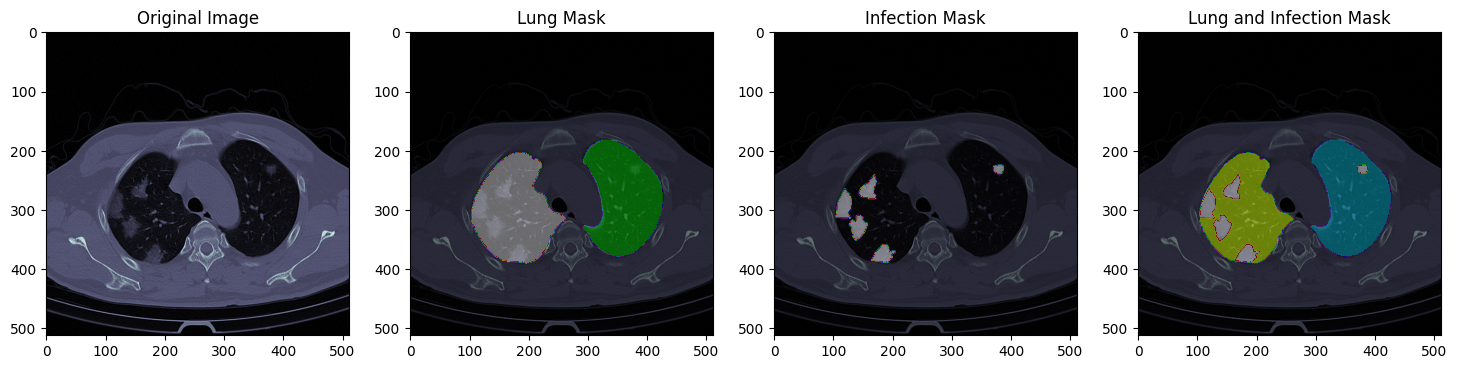

In [7]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.title('Original Image')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung Mask')

plt.subplot(1,4,3)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_infe[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Infection Mask')

plt.subplot(1,4,4)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_all[..., 150], alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Lung and Infection Mask')

In [8]:
IMG_SIZE = 128
IMG_HEIGHT = IMG_SIZE
IMG_WIDTH = IMG_SIZE
IMG_CHANNELS = 1

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

def get_data():
    lungs_data = []
    infections_data  = []

    for row in range(len(raw_data)):
        lungs_image = read_nii(raw_data['ct_scan'][row])
        infection_image = read_nii(raw_data['infection_mask'][row])

        for slice_no in range(lungs_image.shape[2]):
            lung_slice = cv2.resize(lungs_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
            infection_slice = cv2.resize(infection_image[..., slice_no], dsize=(IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA).astype('uint8')
        
            lung_slice_temp = lung_slice.reshape(-1, 2)
            lung_slice_temp = scaler.fit_transform(lung_slice_temp)
            lung_slice = lung_slice_temp.reshape(lung_slice.shape)
            lungs_data.append(lung_slice[..., np.newaxis])

            infections_data.append(infection_slice[..., np.newaxis])
    return lungs_data, infections_data

In [10]:
data = get_data()
lungs = np.array(data[0])
infections = np.array(data[1])

Text(0.5, 1.0, 'Transformed Infection Mask')

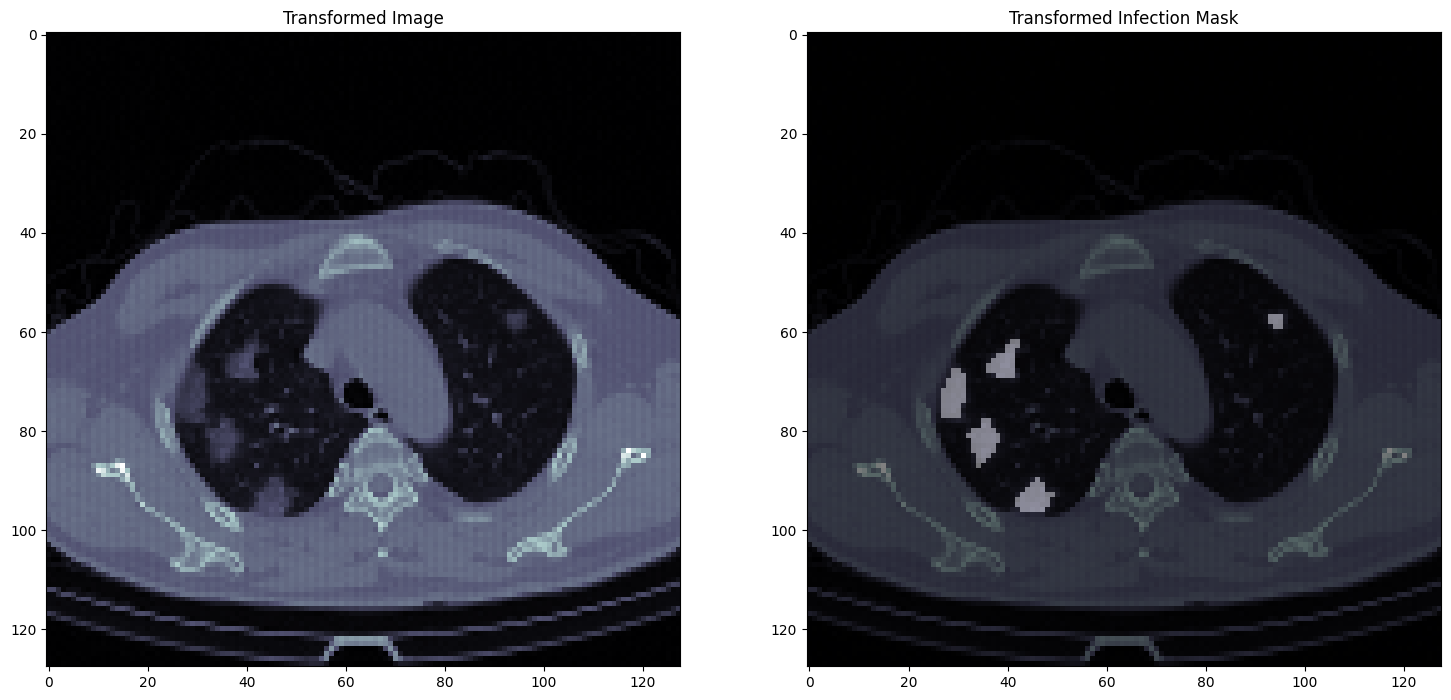

In [11]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,2,1)
plt.imshow(lungs[451], cmap = 'bone')
plt.title('Transformed Image')

plt.subplot(1,2,2)
plt.imshow(lungs[451], cmap = 'bone')
plt.imshow(infections[451],alpha = 0.5, cmap = 'nipy_spectral')
plt.title('Transformed Infection Mask')

In [12]:
# Split the data into train and test sets
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size=0.1, shuffle=True)

In [13]:
lung_train.shape, lung_test.shape, infect_train.shape, infect_test.shape

((3168, 128, 128, 1),
 (352, 128, 128, 1),
 (3168, 128, 128, 1),
 (352, 128, 128, 1))

In [14]:
def encoder_layer(inp, filters):
    conv = Conv2D(filters, 3, padding='same')(inp)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    conv_pool = MaxPool2D((2, 2))(conv)

    return conv, conv_pool

# Converts a single image into multiple patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size
    
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Linearly Transforms patches by projecting it into vector
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = Dense(units=projection_dim)
        self.postion_embedding = Embedding(
            input_dim=num_patches,
            output_dim=projection_dim
        )
    
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.postion_embedding(positions)
        return encoded

# Multi-Layer Perceptrom
def MLP(inp, hidden_units, dropout):
    for units in hidden_units:
        inp = Dense(units)(inp)
        inp = Activation("relu")(inp)
        inp = Dropout(dropout)(inp)
    return inp

# Implements Transformer Layers
def transformer_block(encoded_patches, num_heads, projection_dim, transformer_units, epsilon=1e-6, dropout=0.1):
    x1 = LayerNormalization(epsilon=epsilon)(encoded_patches)
    attention_output = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=projection_dim,
        dropout=dropout
    )(x1, x1)

    x2 = Add()([attention_output, encoded_patches])

    x3 = LayerNormalization(epsilon=epsilon)(x2)
    x3 = MLP(x3, hidden_units=transformer_units, dropout=dropout)
    
    encoded_patches = Add()([x3, x2])
    return encoded_patches

def decoder_layer(inp, pool, skip_connections, filters):
    conv = UpSampling2D(interpolation="bilinear")(inp)
    
    #skip_connections = MaxPool2D(pool)(skip_connections)
    skip_connections = Activation("relu")(skip_connections)

    conv = Concatenate()([conv, skip_connections])

    conv = Conv2D(filters, 3, padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)

    return conv

In [15]:
def TransUnet(inputs, patch_size=16, num_patches=256, projection_dim=256, num_heads=8, transformer_units=[2048, 256], epsilon=1e-6):    
    # Data Augmentation
    # aug = RandomRotation(10)(input_img)
    # aug = RandomZoom(0.1)(aug)
    # aug = RandomContrast(0.1)(aug)
    # aug = GaussianNoise(10)(aug)
    # input_img = aug 

    # Encoder block
    s1, p1 = encoder_layer(inputs, 256)
    s2, p2 = encoder_layer(p1, 128)
    s3, p3 = encoder_layer(p2, 64)

    # Patch extractor and encoder block
    patches = Patches(patch_size=patch_size)(p3)
    encoded_patches = PatchEncoder(num_patches=num_patches, projection_dim=projection_dim)(patches)

    # Transformer block
    transformed_patches = transformer_block(encoded_patches, num_heads=num_heads, projection_dim=projection_dim, transformer_units=transformer_units, epsilon=epsilon)
    transformed_patches = transformer_block(transformed_patches, num_heads=num_heads, projection_dim=projection_dim, transformer_units=transformer_units, epsilon=epsilon)
    transformed_patches = transformer_block(transformed_patches, num_heads=num_heads, projection_dim=projection_dim, transformer_units=transformer_units, epsilon=epsilon)
    transformed_patches = transformer_block(transformed_patches, num_heads=num_patches, projection_dim=projection_dim, transformer_units=transformer_units, epsilon=epsilon)

    # Layer normalization and reshaping
    transformed_patches = LayerNormalization(epsilon=epsilon)(transformed_patches)
    height, width = int(transformed_patches.shape[1]/16), int(transformed_patches.shape[1]/16)
    transformed_patches = tf.reshape(transformed_patches, [-1, height, width, 256])

    # Decoder blocks
    u3 = decoder_layer(transformed_patches, (1, 1), s3, 128)
    u2 = decoder_layer(u3, (2, 2), s2, 64)
    u1 = decoder_layer(u2, (4, 4), s1, 32)

    # Upsampling and final activation
    #conv = UpSampling2D(, interpolation="bilinear")(u1)
    output = Conv2D(1, 1, activation="sigmoid")(u1)

    # Model instantiation
    model = Model(inputs=inputs, outputs=output, name="TransUnet")
    return model

In [16]:
import tensorflow.keras.backend as K

def jaccard_loss(y_true, y_pred, smooth=1e-7):
    y_true = K.cast(y_true, dtype='float32')  # Cast y_true to float32
    intersection = K.sum(y_true * y_pred, axis=(1, 2, 3))
    union = K.sum(y_true, axis=(1, 2, 3)) + K.sum(y_pred, axis=(1, 2, 3)) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return 1 - jaccard

In [17]:
from keras import backend as K
K.clear_session()

# Define the TransUNET model with TensorFlow's MeanIoU metric
input_img = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), name='img')
model = TransUnet(input_img, patch_size=16, num_patches=256, projection_dim=256, num_heads=8, transformer_units=[2048, 256], epsilon=1e-6)
metrics = ["accuracy", 
           tf.keras.metrics.AUC(), 
           tf.keras.metrics.SensitivityAtSpecificity(0.5), 
           tf.keras.metrics.SpecificityAtSensitivity(0.5),
           tf.keras.metrics.MeanIoU(num_classes=2)]  # Use MeanIoU as the Jaccard Index metric
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)  # Use custom Jaccard loss

gc.collect()

728

In [18]:
model.summary()

Model: "TransUnet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 25  2560        ['img[0][0]']                    
                                6)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 25  1024       ['conv2d[0][0]']                 
 alization)                     6)                                                        


(process:31180): GLib-GIO-WARNING **: 16:10:22.586: Unexpectedly, UWP app `18184wherewhere.AndroidAppInstaller_0.1.25.0_x64__4v4sx105x6y4r' (AUMId `18184wherewhere.AndroidAppInstaller_4v4sx105x6y4r!App') supports 4 extensions but has no verbs



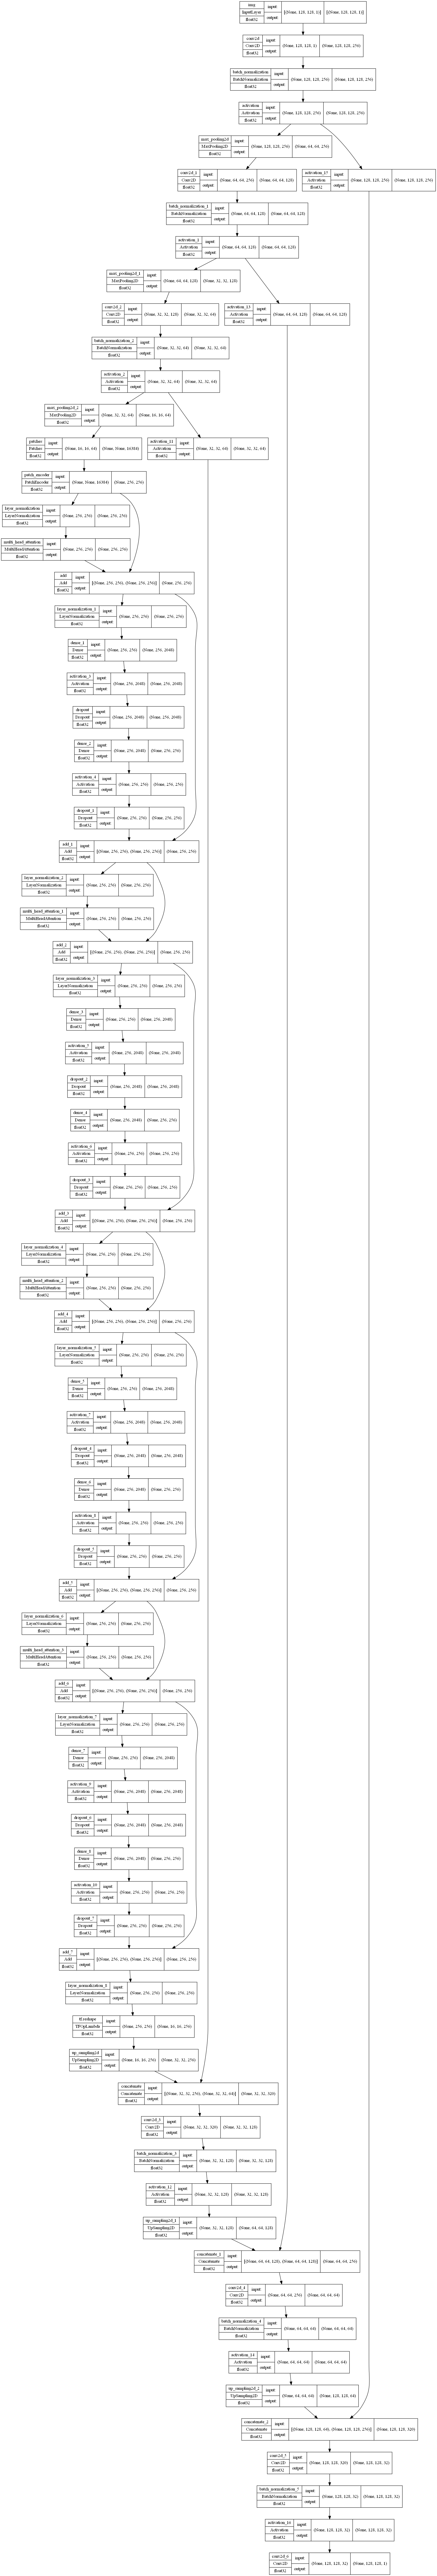

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [20]:
# Define callbacks
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-TransUnet.h5', verbose=1, save_best_only=True, save_weights_only=True),
]

In [21]:
results = model.fit(lung_train, infect_train, batch_size=1, epochs=50, callbacks=[callbacks], validation_data=(lung_test, infect_test), use_multiprocessing=True)

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'TransUnet/multi_head_attention_3/einsum/Einsum' defined at (most recent call last):
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kaush\AppData\Local\Temp\ipykernel_8868\3447408630.py", line 1, in <module>
      results = model.fit(lung_train, infect_train, batch_size=1, epochs=50, callbacks=[callbacks], validation_data=(lung_test, infect_test), use_multiprocessing=True)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\layers\multi_head_attention.py", line 510, in call
      attention_output, attention_scores = self._compute_attention(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\layers\multi_head_attention.py", line 472, in _compute_attention
      attention_scores = tf.einsum(self._dot_product_equation, key,
Node: 'TransUnet/multi_head_attention_3/einsum/Einsum'
Detected at node 'TransUnet/multi_head_attention_3/einsum/Einsum' defined at (most recent call last):
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kaush\AppData\Local\Temp\ipykernel_8868\3447408630.py", line 1, in <module>
      results = model.fit(lung_train, infect_train, batch_size=1, epochs=50, callbacks=[callbacks], validation_data=(lung_test, infect_test), use_multiprocessing=True)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\layers\multi_head_attention.py", line 510, in call
      attention_output, attention_scores = self._compute_attention(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\layers\multi_head_attention.py", line 472, in _compute_attention
      attention_scores = tf.einsum(self._dot_product_equation, key,
Node: 'TransUnet/multi_head_attention_3/einsum/Einsum'
2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[1,256,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node TransUnet/multi_head_attention_3/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[confusion_matrix/assert_less_1/Assert/AssertGuard/pivot_f/_91/_191]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[1,256,256,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node TransUnet/multi_head_attention_3/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_7926]

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

"""Modified"""
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();


In [ ]:
#model.save("TransUnet_JB.h5")

In [ ]:
model = tf.keras.models.load_model(r"model-TransUnet.h5", custom_objects={"Patches":Patches, "PatchEncoder":PatchEncoder}, compile=False)
model.compile()

In [ ]:
# Calculate metrics
predicted = model.predict(lung_test)

# Flatten the predicted and true masks
predicted_flat = np.round(np.array(predicted).flatten())
infect_test_flat = np.array(infect_test).flatten()

ResourceExhaustedError: Graph execution error:

Detected at node 'TransUnet/multi_head_attention_3/key/einsum/Einsum' defined at (most recent call last):
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\traitlets\config\application.py", line 1053, in launch_instance
      app.start()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kaush\AppData\Local\Temp\ipykernel_6256\2656835436.py", line 2, in <module>
      predicted = model.predict(lung_test)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1982, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1801, in predict_function
      return step_function(self, iterator)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1790, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1783, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
      return self(x, training=False)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\layers\multi_head_attention.py", line 505, in call
      key = self._key_dense(key)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kaush\anaconda3\envs\TensorflowEnv\lib\site-packages\keras\layers\einsum_dense.py", line 187, in call
      ret = tf.einsum(self.equation, inputs, self.kernel)
Node: 'TransUnet/multi_head_attention_3/key/einsum/Einsum'
OOM when allocating tensor with shape[8192,65536] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node TransUnet/multi_head_attention_3/key/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_2331]

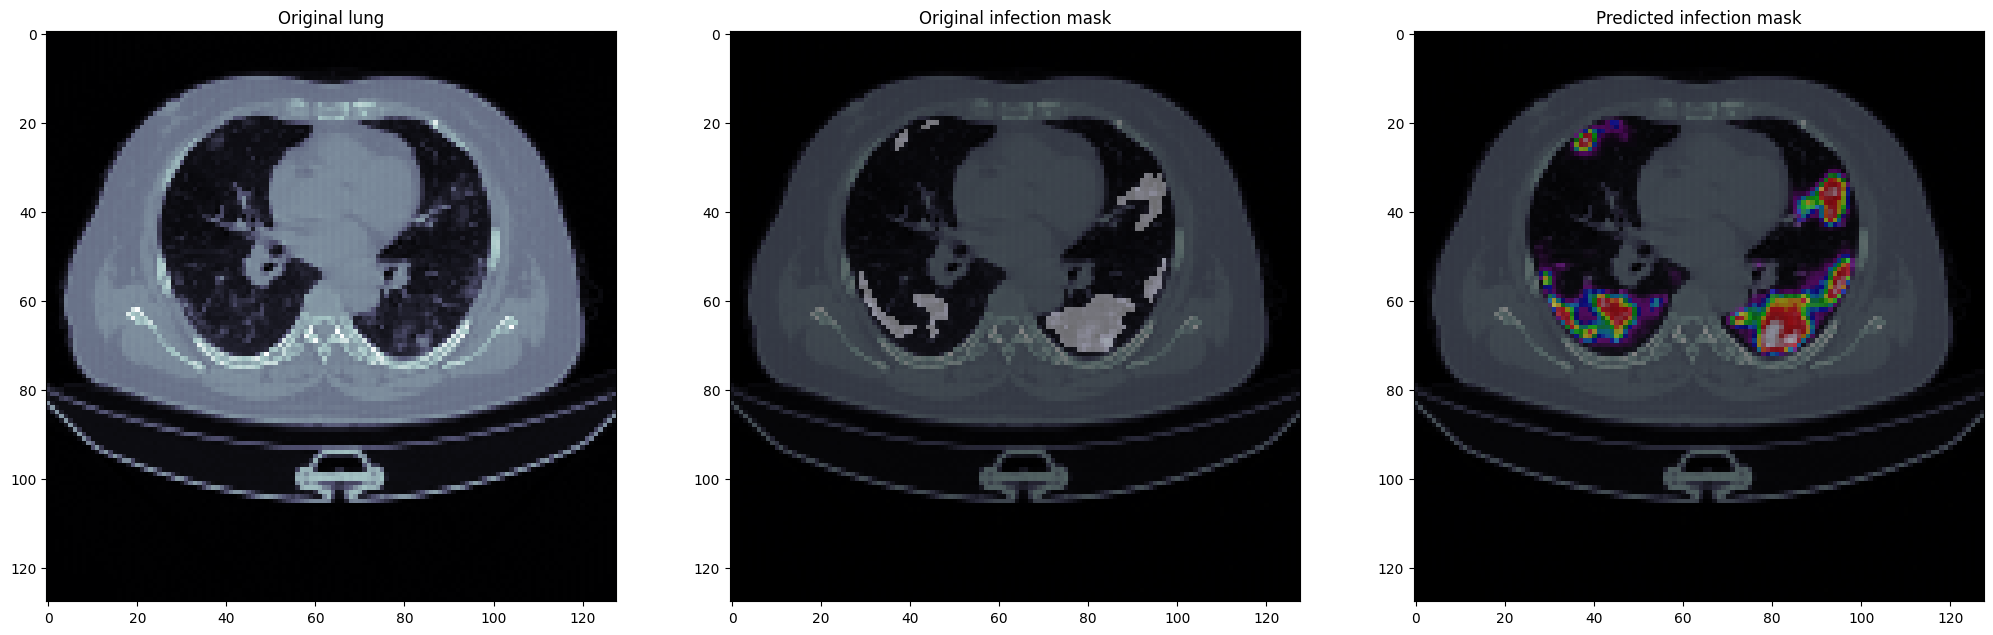

In [ ]:
img = 6
predicted = model.predict(lung_test[img: img+1])
predicted_flat = np.round(np.array(predicted).flatten())
infect_test_flat = np.array(infect_test).flatten()
num = len(predicted)
for img_num in range(num):
    img_num = img
    fig = plt.figure(figsize=(25, 75))
    plt.subplot(num, 3, 1)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.title('Original lung')
    plt.subplot(num, 3, 2)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.imshow(infect_test[img_num][..., 0], alpha=0.5, cmap="nipy_spectral")
    plt.title('Original infection mask')
    plt.subplot(num, 3, 3)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.imshow(predicted[0], alpha=0.5, cmap="nipy_spectral")
    plt.title('Predicted infection mask')

In [ ]:
# Calculate metrics for training data
train_predicted = model.predict(lung_train[:1])

# Calculate metrics for testing data
test_predicted = model.predict(lung_test)

KeyboardInterrupt: 

In [ ]:
# Flatten the predicted and true masks
train_predicted_flat = np.round(np.array(train_predicted)[0, :, :, :].flatten())
infect_train_flat = np.array(infect_train)[:, :, :, 0].flatten()

# Calculate precision and recall for training data
train_precision = Precision()
train_recall = Recall()
train_precision.update_state(infect_train_flat, train_predicted_flat)
train_recall.update_state(infect_train_flat, train_predicted_flat)

# Calculate F1 score for training data
train_f1_score = 2 * (train_precision.result() * train_recall.result()) / (train_precision.result() + train_recall.result())

# Calculate accuracy for training data
train_accuracy = np.mean(train_predicted_flat == infect_train_flat)


# Flatten the predicted and true masks for testing data
test_predicted_flat = np.round(np.array(test_predicted)[0, :, :, :].flatten())
infect_test_flat = np.array(infect_test)[:, :, :, 0].flatten()

# Calculate precision and recall for testing data
test_precision = Precision()
test_recall = Recall()
test_precision.update_state(infect_test_flat, test_predicted_flat)
test_recall.update_state(infect_test_flat, test_predicted_flat)

# Calculate F1 score for testing data
test_f1_score = 2 * (test_precision.result() * test_recall.result()) / (test_precision.result() + test_recall.result())

# Calculate accuracy for testing data
test_accuracy = np.mean(test_predicted_flat == infect_test_flat)

# Calculate parameters
total_parameters = np.sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

# Calculate FLOPs
# flops = get_flops(model, batch_size=1)  # Assuming batch_size = 1

# Print the metrics for training data
print("Training Metrics:")
print("Precision: ", train_precision.result().numpy())
print("Recall: ", train_recall.result().numpy())
print("F1 Score: ", train_f1_score.numpy())
print("Accuracy: ", train_accuracy)

# Print the metrics for testing data
print("\nTesting Metrics:")
print("Precision: ", test_precision.result().numpy())
print("Recall: ", test_recall.result().numpy())
print("F1 Score: ", test_f1_score.numpy())
print("Accuracy: ", test_accuracy)

# Print the other metrics
print("\nTotal Parameters: ", total_parameters)
# print("FLOPs: ", flops)


In [ ]:
# Calculate Jaccard Index (MeanIoU) for training data
train_iou = tf.keras.metrics.MeanIoU(num_classes=2)
train_iou.update_state(infect_train_flat, train_predicted_flat)
train_mean_iou = train_iou.result().numpy()

# Calculate Jaccard Index (MeanIoU) for testing data
test_iou = tf.keras.metrics.MeanIoU(num_classes=2)
test_iou.update_state(infect_test_flat, test_predicted_flat)
test_mean_iou = test_iou.result().numpy()

# Print the Jaccard Index (MeanIoU) for training and testing data
print("Training Jaccard Index (MeanIoU): ", train_mean_iou)
print("Testing Jaccard Index (MeanIoU): ", test_mean_iou)


In [ ]:
# Plot accuracy
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

NameError: name 'results' is not defined

In [ ]:
# Make predictions
predicted = model.predict(lung_test)

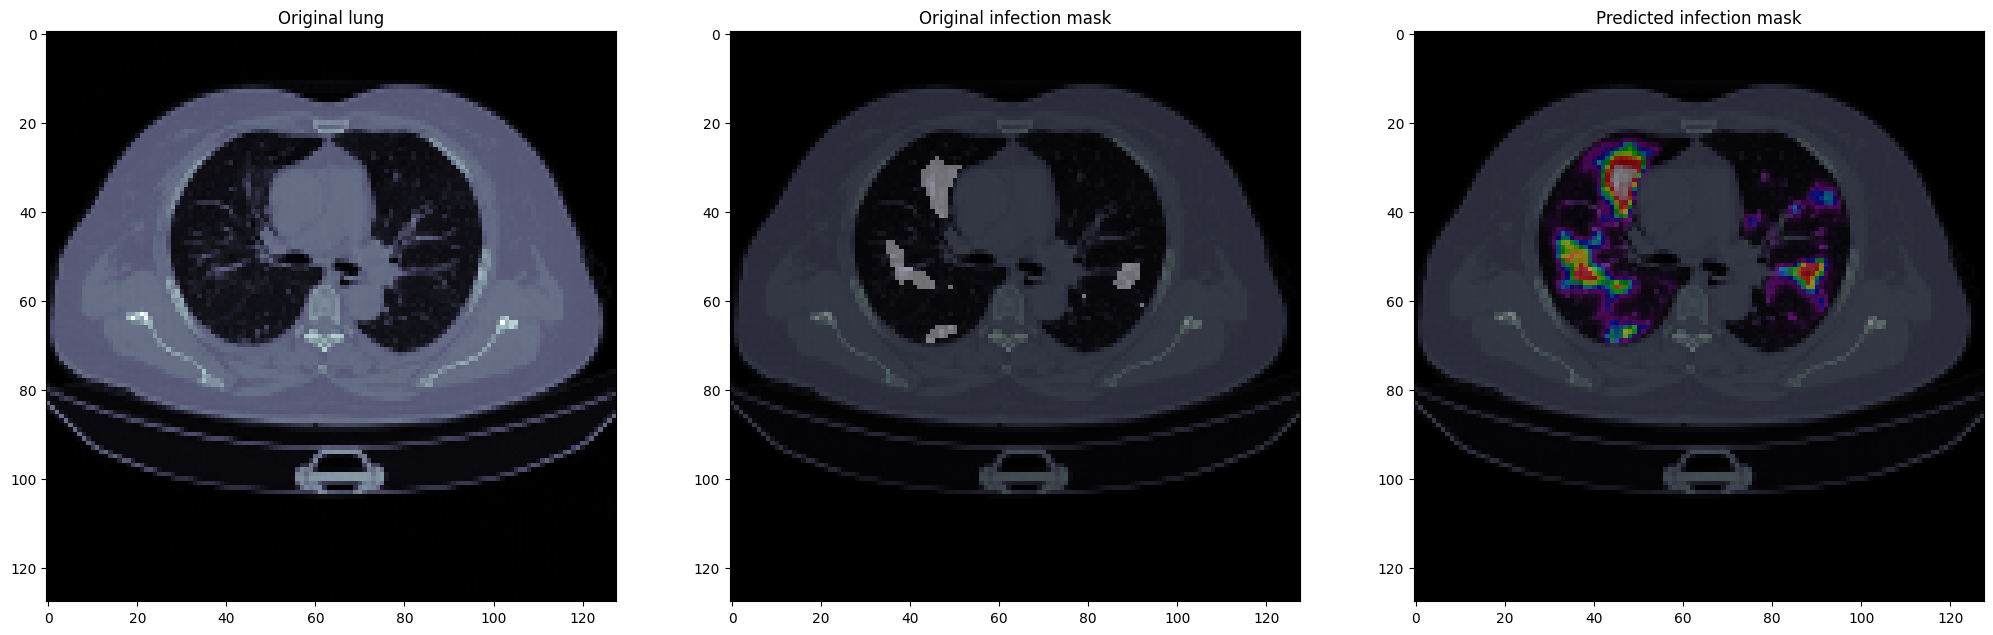

In [ ]:
# Make predictions and visualize
num = len(predicted)

for img_num in range(num):
    # predicted = model.predict(lung_test)
    # Visualize results
    fig = plt.figure(figsize=(25, 75))
    plt.subplot(num, 3, 1)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.title('Original lung')

    plt.subplot(num, 3, 2)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.imshow(infect_test[img_num][..., 0], alpha=0.5, cmap="nipy_spectral")
    plt.title('Original infection mask')

    plt.subplot(num, 3, 3)
    plt.imshow(lung_test[img_num], cmap='bone')
    plt.imshow(predicted[img_num], alpha=0.5, cmap="nipy_spectral")
    plt.title('Predicted infection mask')

In [ ]:
# Plot Jaccard Index (MeanIoU)
plt.plot(results.history['mean_io_u'])
plt.plot(results.history['val_mean_io_u'])
plt.title('MeanIoU (Jaccard Index) vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('MeanIoU (Jaccard Index)')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
model.save_weights("TransUnet_JB.h5")